In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, pi
from scipy import signal
from matplotlib import cm

%matplotlib inline
plt.style.use("ggplot")
# plt.rcParams.update(
#     {
#         "text.usetex": True,
#         "font.family": "typeface",
#     }
# )  # Makes plotting slower but prettier (requires LaTeX installed)


Calculations will be assumed to be done in the far field, or where the propagating wave resembles a plane wave. The boundary between the near and far fields are not definitive, but the Fraunhofer distance is a commonly used approximation:
## <center>Fraunhofer distance: $d_f = \frac{2D^2}{\lambda}$ </center>

In [16]:
D_x = 0.5
D_y = 1
f = 10e9
wavelength = c/f
D = max(D_x, D_y)
d_f = (2*D**2)/wavelength
print(f"For a {D_x:.1f} x {D_y:.1f} m^2 antennat at frequency {f/(1e9):.1f} GHz, the Fraunhofer distance would be d_f = {d_f:.2f} m")

For a 0.5 x 1.0 m^2 antennat at frequency 10.0 GHz, the Fraunhofer distance would be d_f = 66.71 m


## Compute the requires phase shift $\Delta \phi$ to steer the beam toward the desired angle
### <center>$\Delta \phi = \frac{2\pi}{\lambda} d_x sin(\theta)$</center>
### Sample details abstract computational could be found at [Antenna Array Beamforming Demystification](https://evaristesome.github.io/antenna-array-beamforming-demystification.html)

In [3]:
#Setup
f_0 = 10e9   # Center frequency for computing phase shift
wavelength_0 = c/f_0
k_0 = 2*pi/wavelength_0   # Wave number
d_x = wavelength_0/2    # Element spacing
N = 8  # Number of elements

steering_angle = 0
u_0 = np.sin(steering_angle * pi/100)
theta = np.linspace(-pi,pi,1000)   # Theta value for plotting
u = np.sin(theta)   # theta in sine space
scan_to = 20  # degrees
scan_to_rad = scan_to * pi/180   # in radian
phase_shift = 2*pi/wavelength_0 * d_x * np.sin(scan_to_rad)  # phase shift in radian
phase_shift_deg = phase_shift * 180/pi
print(f"To scan to {scan_to:.1f} degrees of boresight with an operating frequency of {f_0/1e9:.1f} GHz, a phase shift of {phase_shift_deg:.1f} degree is needed.")

To scan to 20.0 degrees of boresight with an operating frequency of 10.0 GHz, a phase shift of 61.6 degree is needed.


## Antenna Patterm
#### Approximation method using
### <center>F(u) = $\frac{sin[N\pi d_x (u - u_0) / \lambda_0]}{N sin[\pi d_x (u - u_0) / \lambda_0]}$</center>

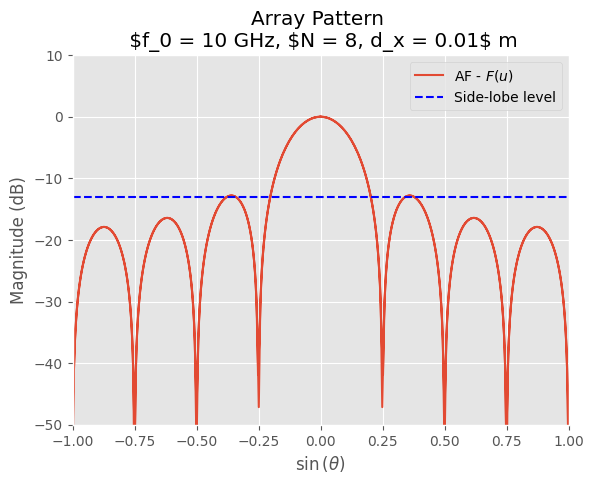

In [4]:
AF = np.sin(N*pi*d_x*(u - u_0) / wavelength_0) / (N*np.sin(pi * d_x * (u - u_0) / wavelength_0))

fig, ax = plt.subplots()
ax.plot(u, 20*np.log10(np.abs(AF)), label = "AF - $F(u)$")
ax.set_xlim(-1,1)
ax.set_ylim(-50, 10)
ax.axhline(-13, c="b", linestyle="--", label="Side-lobe level")
ax.set_xlabel(r"$\sin{(\theta)}$")
ax.set_ylabel(r"Magnitude (dB)")
ax.set_title(f"Array Pattern \n $f_0 = {f_0 / 1e9:.0f} GHz, $N = {N}, d_x = {d_x:.2f}$ m")
ax.legend()
plt.show()

## Antenna Array 2D
### <center>$F(\theta, \phi) = \sum_{m}^{M}\sum_{n}^{N} |a_{nm}| exp{jk_0 [m d_x (u - u_0) + nd_y (v - v_0)]}$</center>
### Or, if $a_{m,n}$ is separable to $a_{m,n} = b_m c_n$ , then
### <center>$F(\theta, \phi) = {\sum_{b_m} exp[jk_0 md_x (u - u_0)]} {\sum_{c_n} exp[jk_0 nd_y (v - v_0)]}$</center>

In [5]:
N = 16  # Number of elements in horizontal dimension
M = 16  # Number of elements in vertical dimension

n = np.arange(N)  # Array for summing over N
m = np.arange(M)  # Array for summing over M
d_x = wavelength_0 / 2  # spacing between horizontal antenna elements
d_y = wavelength_0 / 2  # spacing between vertical antenna elements

steering_angle_theta = 0  # theta steering angle
steering_angle_phi = 0  # phi steering angle

u_0 = np.sin(steering_angle_theta * pi / 180)  # theta steering angle in sine space
v_0 = np.sin(steering_angle_phi * pi / 180)  # phi steering angle in sine space

In [6]:
npts = 100
theta = np.linspace(-pi,pi,npts)
phi = np.linspace(-pi,pi,npts)

u2 = np.sin(theta) * np.cos(phi)
v2 = np.sin(theta) * np.sin(phi)

u2 = np.linspace(-1,1,npts)
v2 = np.linspace(-1,1,npts)

U, V = np.meshgrid(u2, v2)  # meshgrid of sine space

In [7]:
def compute_af_2d(weights_n, weights_m, d_x, d_y, k_0, u_0, v_0):
    AF_m = np.sum(weights_n[:, None, None] * np.exp(1j * n[:, None, None] * d_x * k_0 * (U - u_0)), axis=0, )
    AF_n = np.sum(weights_m[:, None, None] * np.exp(1j * m[:, None, None] * d_y * k_0 * (V - u_0)), axis=0, )
    AF = AF_m * AF_n / (M*N)
    return AF
    

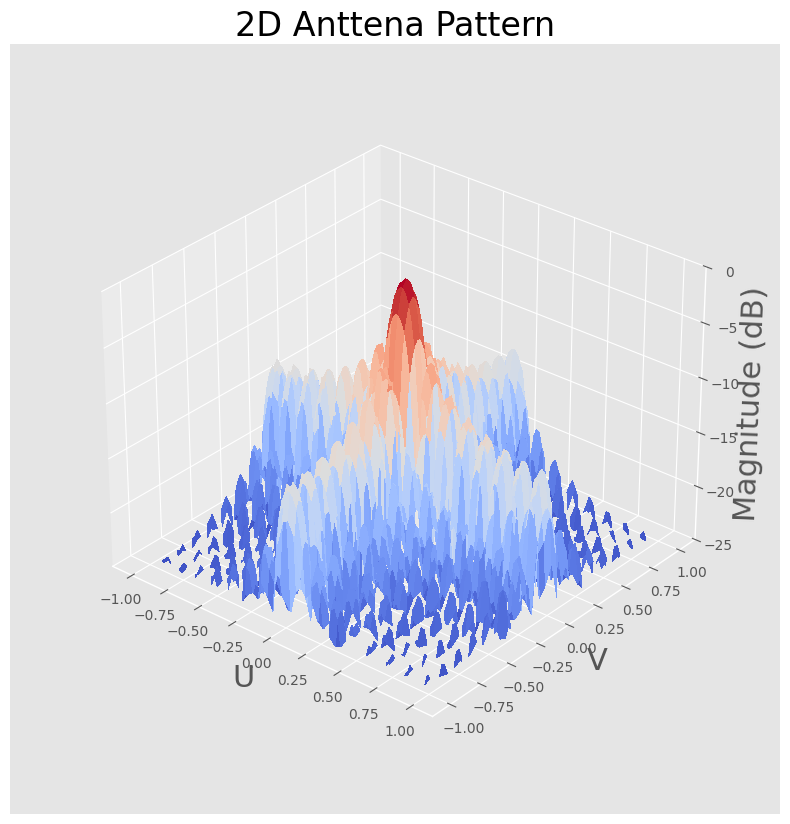

In [8]:
# Rectangular Weighting
%matplotlib inline

z_min = -25
z_max = 0

weights_n = np.ones(N)
weights_m = np.ones(M)
AF_rect = compute_af_2d(weights_n, weights_m, d_x, d_y, k_0, u_0, v_0)
AF_rect_log = 10 * np.log10(np.abs(AF_rect))
AF_rect_log_mask = np.where(AF_rect_log > z_min, AF_rect_log, np.nan)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(U, V, AF_rect_log_mask, cmap = cm.coolwarm, antialiased=False)
ax.set_zlim(z_min, z_max)
ax.set_title("2D Anttena Pattern", fontsize=24)
ax.set_xlabel("U", fontsize=22)
ax.set_ylabel("V", fontsize=22)
ax.set_zlabel("Magnitude (dB)", fontsize=22)
ax.view_init(elev=30, azim=-50, roll=0)
ax.set_box_aspect(None, zoom = 0.85)
plt.show()